Class 0 - AUC: 0.93
Class 1 - AUC: 0.93
Class 2 - AUC: 0.92
Micro-Average AUC: 0.94


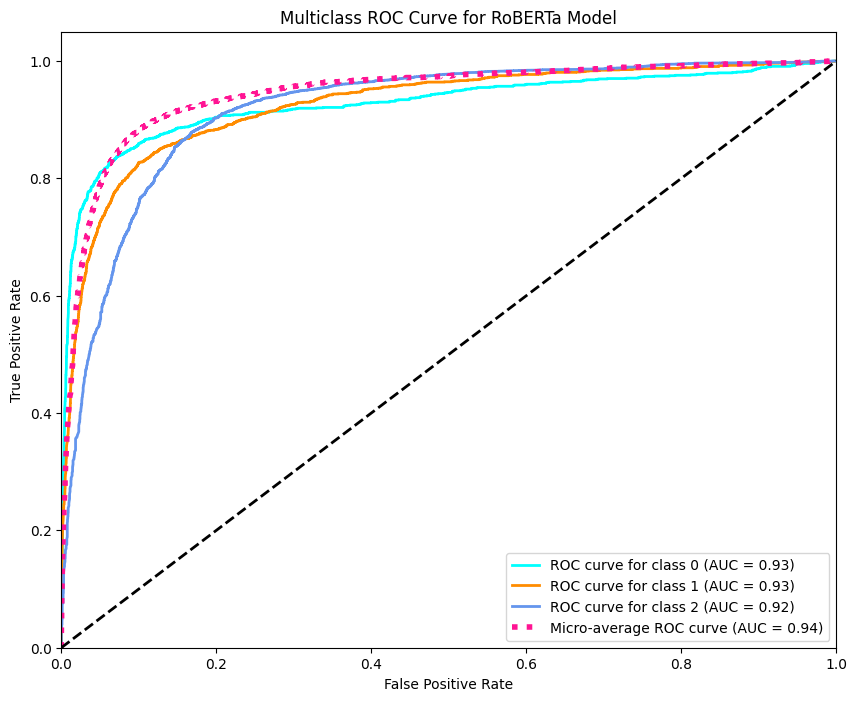

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Load model and tokenizer
checkpoint_path = "./final_finetuned_model"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, local_files_only=True)
model.eval()  # Set the model to evaluation mode

# 2. Load your data into a DataFrame.  
df = pd.read_csv("cleaning/tweets_cleaned.csv")
df["clean_text"]=df["clean_text"].str.replace(r"http\S+", "",regex=True)
df = df.rename(columns={"clean_text":"text"})

# Extract texts and labels
texts = df["text"].tolist()
y_test = df["label"].values

# 3. Define your batch size
batch_size = 16

# 4. Prepare a list to store predictions from the model
y_scores_list = []

# 5. Process data in batches
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i : i + batch_size]
    
    # Ensure batch_texts is a list of strings
    if isinstance(batch_texts, list):  # Ensure the batch is a list
        batch_texts = [str(text) for text in batch_texts]  # Convert all elements to strings
    else:
        # If not a list, convert it to a list of strings
        batch_texts = [str(batch_texts)]
    
    # Tokenize the batch
    encoded_inputs = tokenizer(batch_texts, 
                               padding=True, 
                               truncation=True, 
                               max_length=512, 
                               return_tensors="pt")
    
    # Move inputs and model to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    encoded_inputs = {key: value.to(device) for key, value in encoded_inputs.items()}
    model.to(device)
    
    # Inference without computing gradients
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        logits = outputs.logits  # logits shape: [batch_size, n_classes]
        probs = F.softmax(logits, dim=1)  # shape: [batch_size, n_classes]
        y_scores_list.append(probs.cpu().numpy())

# Concatenate all batch predictions into a single numpy array
y_scores = np.concatenate(y_scores_list, axis=0)

# 6. Binarize the true labels for one-vs-rest ROC calculation:
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

# 7. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Class {classes[i]} - AUC: {roc_auc[i]:.2f}")

# Optionally, compute a micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(f"Micro-Average AUC: {roc_auc['micro']:.2f}")

# 8. Plot the ROC curves for each class along with the micro-average ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             lw=2, label=f'ROC curve for class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for RoBERTa Model')
plt.legend(loc="lower right")
plt.show()
